In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Image settings
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Paths (reuse the ones from EDA notebook)
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


In [3]:
# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
# Load pre-trained VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Final model
model = Model(inputs=base_model.input, outputs=predictions)


In [5]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [6]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Create a folder to save best model
checkpoint_path = "best_vgg16_model.h5"

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=1,  # 🔧 Force at least 1 batch to get val_accuracy
    epochs=20,
    callbacks=[early_stop, model_checkpoint]
)


Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7339
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_vgg16_model.h5
163/163 [==============================] - 223s 1s/step - loss: 0.5526 - accuracy: 0.7339 - val_loss: 0.7202 - val_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.7638
Epoch 2: val_accuracy improved from 0.50000 to 0.56250, saving model to best_vgg16_model.h5
163/163 [==============================] - 228s 1s/step - loss: 0.4582 - accuracy: 0.7638 - val_loss: 0.6526 - val_accuracy: 0.5625
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8416
Epoch 3: val_accuracy improved from 0.56250 to 0.68750, saving model to best_vgg16_model.h5
163/163 [==============================] - 225s 1s/step - loss: 0.3498 - accuracy: 0.8416 - val_loss: 0.6313 - val_accuracy: 0.6875
Epoch 4/20
163/163 [=======================

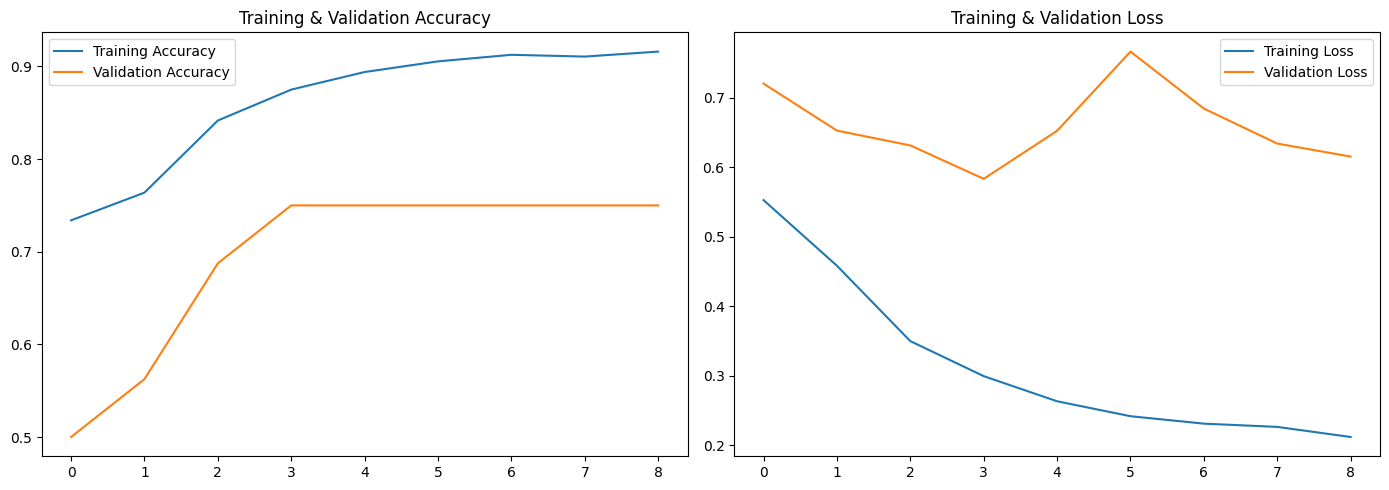

In [9]:
# Plot accuracy & loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)
